# モジュール

In [1]:
import os
import sys
import warnings

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
sys.path.append(os.getcwd())
sys.path.append("..")
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
# TF/Keras
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.layers import Input, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.manifold import TSNE



In [2]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# フォントの設定
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = [
    "Hiragino Gothic Pro",
    "Yu Gothic",
    "Meirio",
    "Takao",
    "IPAexGothic",
    "IPAPGothic",
    "VL PGothic",
    "Noto Sans CJK JP",
]
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["font.size"] = 17
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
# 軸の設定
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["axes.linewidth"] = 2.0
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams["axes.axisbelow"] = True
plt.rcParams["grid.color"] = "black"

# 凡例の設定
plt.rcParams["legend.frameon"] = True
plt.rcParams["legend.framealpha"] = 0.0
plt.rcParams["legend.handlelength"] = 1.0
plt.rcParams["legend.labelspacing"] = 0.4
plt.rcParams["legend.handletextpad"] = 0.8
plt.rcParams["legend.markerscale"] = 1.0

# Data



In [3]:

def make_timeseries_dataset(data, target, timesteps):
    #タイムステップ分ずらす
    N = len(target[timesteps:])
    X = np.zeros((N, timesteps, 1), np.float32)
    Y = np.zeros((N, 1), np.float32)
    for i in range(N):
        X[i] = data[i:i+timesteps][:,np.newaxis]
        Y[i] = target[i+timesteps]
    return X, Y

def make_dataset_for_stateful(data_list, target_list, timesteps):
    N = len(data_list)
    X = []
    Y = []
    for i in range(N):
        x, y = make_timeseries_dataset(data_list[i], target_list[i], timesteps)
        X.append(x)
        Y.append(y)
    X = np.concatenate(X, axis=(1)).reshape(-1, timesteps, 1)
    Y = np.concatenate(Y, axis=(1)).reshape(-1, 1)

    return X, Y

# Model

In [4]:
def build_encoder(input_shape, h_dim, z_dim, name="encoder"):
    #入力層
    inputs = keras.layers.Input(shape=input_shape)
    #隠れ層，h_dim個のユニット，ReLU関数
    #入力データを非線形変換
    x = keras.layers.Dense(h_dim, activation="relu")(inputs)
    #別の隠れ層，ネットワークの表現能力を向上
    x = keras.layers.Dense(h_dim, activation="relu")(x)
    z_mean = keras.layers.Dense(z_dim, name="z_mean")(x)
    z_log_var = keras.layers.Dense(z_dim, name="z_log_var")(x)
    #潜在空間の平均と対数分散を出力
    outputs = [z_mean, z_log_var]
    
    
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

#事前モデル分布
def build_prior(input_shape, h_dim, z_dim, name="prior"):
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.Dense(h_dim, activation="relu")(inputs) 
    prior_mean = keras.layers.Dense(z_dim, name="prior_mean")(x)
    prior_log_var = keras.layers.Dense(z_dim, name="prior_log_var")(x)
    #潜在空間の事前分布の平均を出力
    outputs = [prior_mean, prior_log_var]
    
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

def build_decoder(input_shape, h_dim, x_dim, name="decoder"):
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.Dense(h_dim, activation="relu")(inputs)
    x = keras.layers.Dense(h_dim, activation="relu")(x)
    x = keras.layers.Dense(x_dim)(x)
    outputs = x
    
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

class Sampling(keras.layers.Layer):
    def __init__(self, name="sampling"):
        super().__init__(name=name)
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        #潜在変数 = 期待値(u) + 標準偏差(σ) * 乱数
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
class VRNNCell(keras.layers.Layer):
    def __init__(self, h_dim, z_dim):
        super().__init__()
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.state_size = h_dim

    def build(self, input_shape):
        batch_size, x_dim = input_shape

        #phi 特徴抽出
        self.phi_x_layer = keras.Sequential([
            keras.layers.Input((x_dim)),
            keras.layers.Dense(self.h_dim, activation="relu"),
            keras.layers.Dense(self.h_dim, activation="relu")
        ])
        self.phi_z_layer = keras.layers.Dense(self.h_dim, activation="relu")
        self.encoder = build_encoder(input_shape=(self.h_dim+self.h_dim), h_dim=self.h_dim, z_dim=self.z_dim)
        self.prior_layer = build_prior(input_shape=(self.h_dim), h_dim=self.h_dim, z_dim=self.z_dim)
        self.decoder = build_decoder(input_shape=(self.h_dim+self.h_dim), h_dim=self.h_dim, x_dim=x_dim)

        self.rnn_cell = keras.layers.GRUCell(self.h_dim)

        self.sampling_layer = Sampling()

    def call(self, inputs, states):
        h = states[0]   # B x h_dim

        phi_x = self.phi_x_layer(inputs)    # B x h_dim
        x = keras.layers.Concatenate(axis=(1))([phi_x, h])  # B x h_dim+h_dim

        # encoder
        z_mean, z_log_var = self.encoder(x)     # B x z_dim, B x z_dim

        # prior
        prior_mean, prior_log_var = self.prior_layer(h)     # B x z_dim, B x z_dim

        # reparametrization trick
        z = self.sampling_layer([z_mean, z_log_var])    # B x z_dim

        phi_z = self.phi_z_layer(z)     # B x z_dim
        x = keras.layers.Concatenate(axis=(1))([phi_z, h])  # B x h_dim+h_dim

        #decoder
        y = self.decoder(x)   # B x z_dim

        #recurrence
        phi = keras.layers.Concatenate(axis=(1))([phi_x, phi_z])
        _, new_h = self.rnn_cell(phi, [h])    # B x h_dim

        outputs = [y, z_mean, z_log_var, prior_mean, prior_log_var, z, phi_z, h]
        new_states = [new_h]    # 1 x B x h_dim
        return outputs, new_states

In [6]:
class VRNN(keras.Model):
    def __init__(self, input_shape, h_dim=100, z_dim=32, return_sequences=False, name="vrnn", *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)
        self.cell = VRNNCell(h_dim=h_dim, z_dim=z_dim)
        self.axis = (1, 2) if return_sequences else (1)

        # build model
        inputs = keras.layers.Input(input_shape)
        x = keras.layers.RNN(self.cell, return_sequences=return_sequences)(inputs)
        outputs = x
        self.rnn = keras.Model(inputs=inputs, outputs=outputs)

    def call(self, inputs, training=False):
        return self.rnn(inputs)
    
    def compile(self, optimizer, loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.optimizer = optimizer
        self.loss = loss

        # Tracker
        self.total_cost_tracker = keras.metrics.Mean(name="total_cost")
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.kl_tracker = keras.metrics.Mean(name="kl_divergence")

    @property
    def metrics(self):
        return [
            self.total_cost_tracker,
            self.loss_tracker,
            self.kl_tracker
        ]

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape:
            outputs = self.rnn(x)
            y_pred, z_mean, z_log_var, prior_mean, prior_log_var, z, phi_z, h = outputs

            # loss
            loss = tf.reduce_mean(self.loss(y_true, y_pred))

            # KL-divergence
            term1 = prior_log_var - z_log_var
            term2 = (tf.exp(z_log_var) + tf.square(z_mean - prior_mean)) / (tf.exp(prior_log_var) + 1e-12)
            term3 = -1
            kl = tf.reduce_mean(tf.reduce_sum(0.5 * (term1 + term2 + term3), axis=self.axis))

            # term1 = (prior_log_var - z_log_var)
            # term2 = (tf.exp(z_log_var) + tf.square(z_mean - prior_mean)) / (2 * tf.exp(prior_log_var) + 1e-12)
            # term3 = -0.5
            # kl = tf.reduce_mean(tf.reduce_sum((term1 + term2 + term3), axis=self.axis))

            total_cost = loss + kl

        grads = tape.gradient(total_cost, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update
        self.total_cost_tracker.update_state(total_cost)
        self.loss_tracker.update_state(loss)
        self.kl_tracker.update_state(kl)
        
        return {m.name: m.result() for m in self.metrics}

#  データの取得

## new

In [7]:
# new
Q_876 = pd.read_csv('/data/Users/tsutsumi/VRNN/data/Original_Data/Figure3/paQuasAr3_dia10-8_-7_-6.csv', encoding='utf-8')
G_876 = pd.read_csv('/data/Users/tsutsumi/VRNN/data/Original_Data/Figure3/GCaMP_dia10-8_-7_-6.csv', encoding='utf-8')

# NumPy 配列に変換
Q_876_numpy = Q_876.to_numpy()
G_876_numpy = G_876.to_numpy()

# 配列の転置（N x Tにする）(27, 1199)
x_Q876 = Q_876.to_numpy().transpose((1, 0))
x_G876 = G_876.to_numpy().transpose((1, 0))

x_Q876x200 = (x_Q876-1) * 800
x_G876x200 = (x_G876-1) * 400


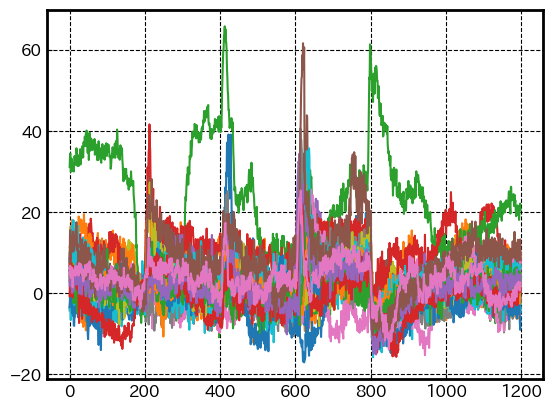

In [52]:
t1 = np.linspace(0, 1199, 1199)
for i in range (len(x_Q876x200)):
    plt.plot(t1, x_Q876x200[i, :])


In [30]:
frames = np.arange(1199)

# 矩形波の生成
def create_square_wave(frames):
    square_wave = np.full_like(frames, fill_value=1, dtype=float)
    square_wave[(frames >= 200) & (frames < 400)] = 1
    square_wave[(frames >= 400) & (frames < 600)] = 10
    square_wave[(frames >= 600) & (frames < 800)] = 100
    return square_wave

# 7つの矩形波を作成
x_si = np.array([create_square_wave(frames) for _ in range(27)])


In [31]:
proj_data = np.load(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/slice100/z4h32rate001/proj_all.npy")

In [10]:
proj_data.shape

(1099, 34)

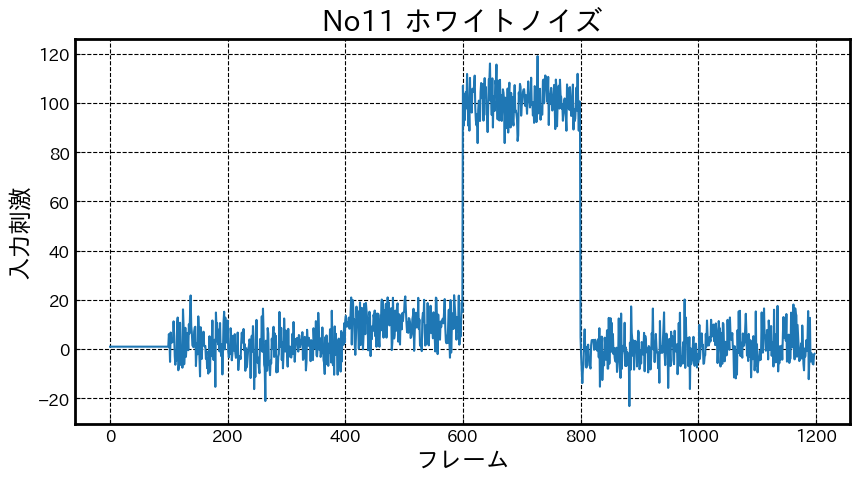

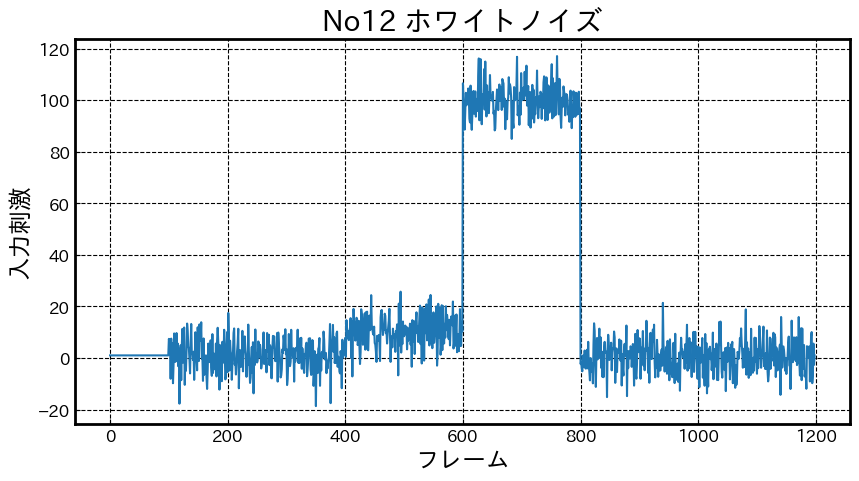

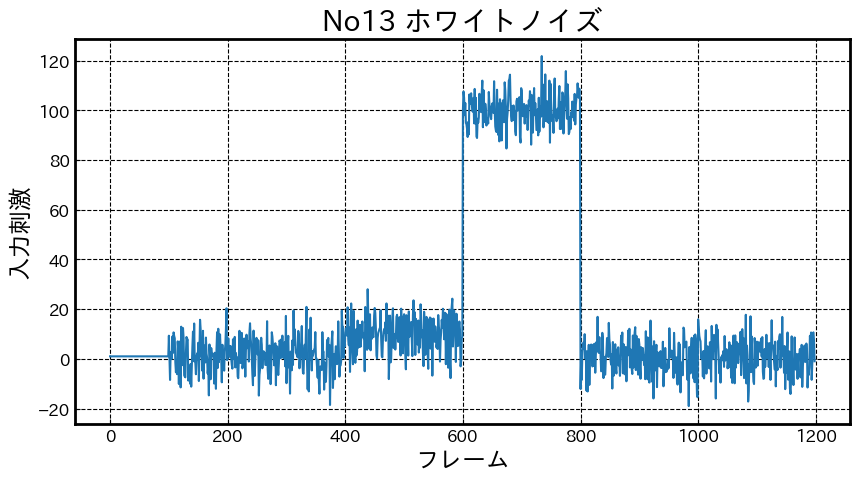

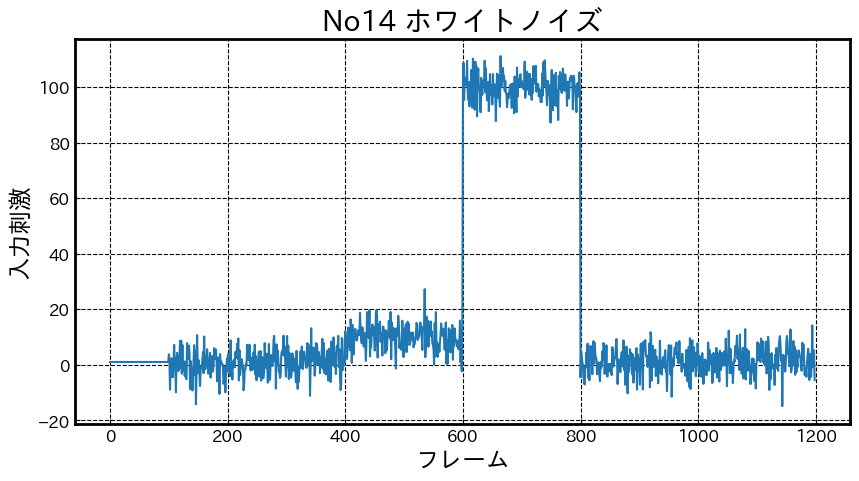

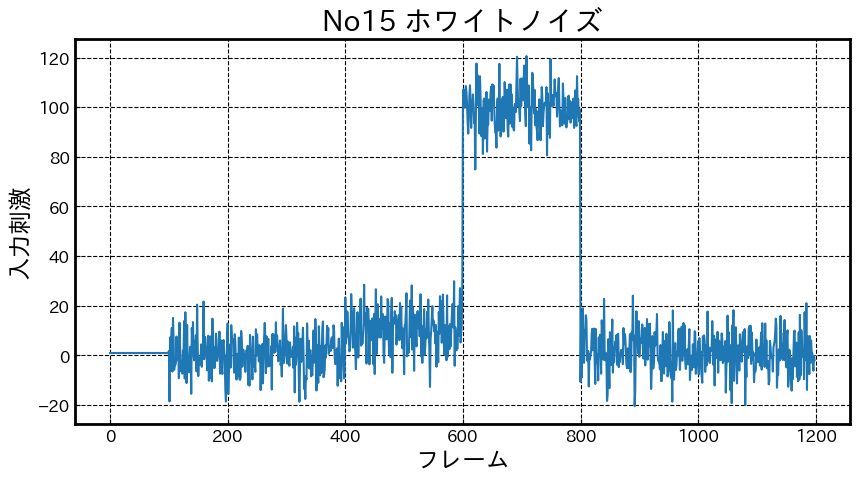

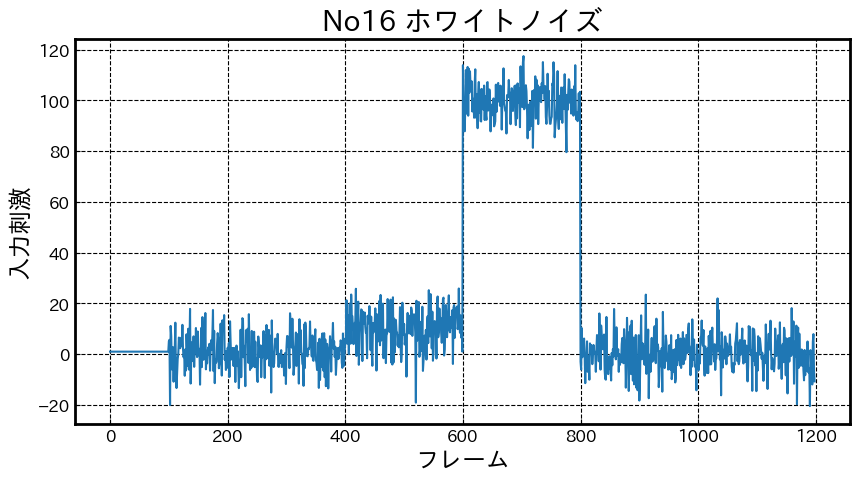

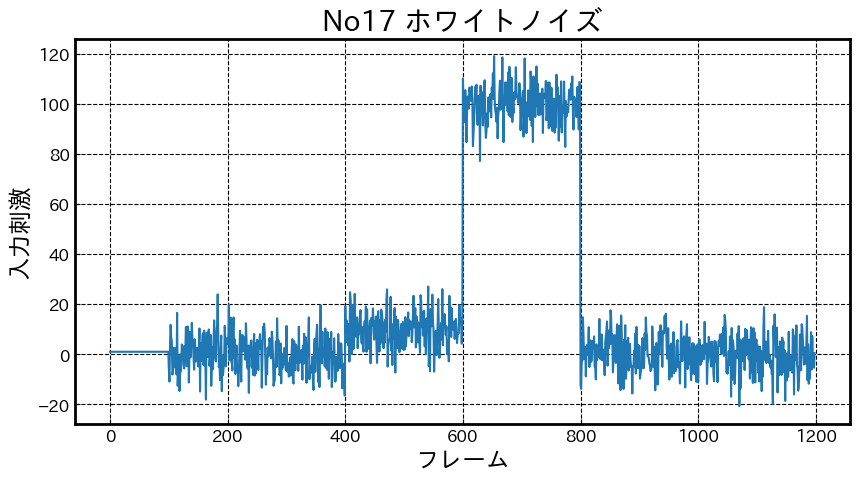

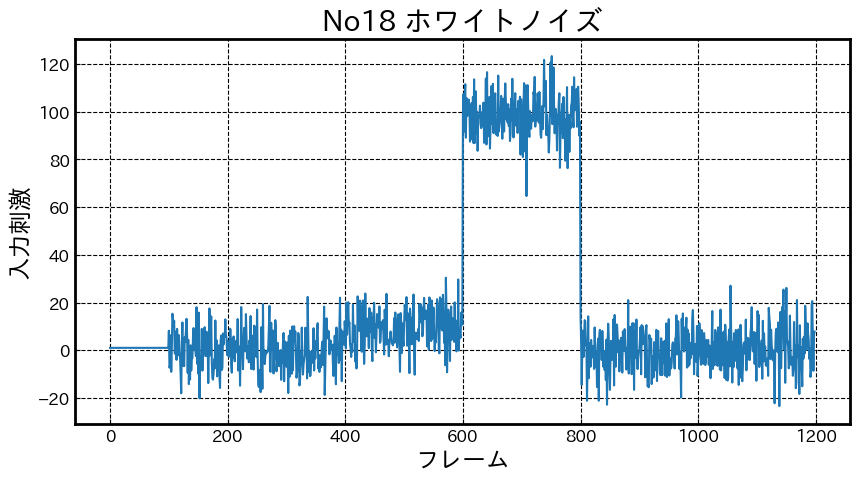

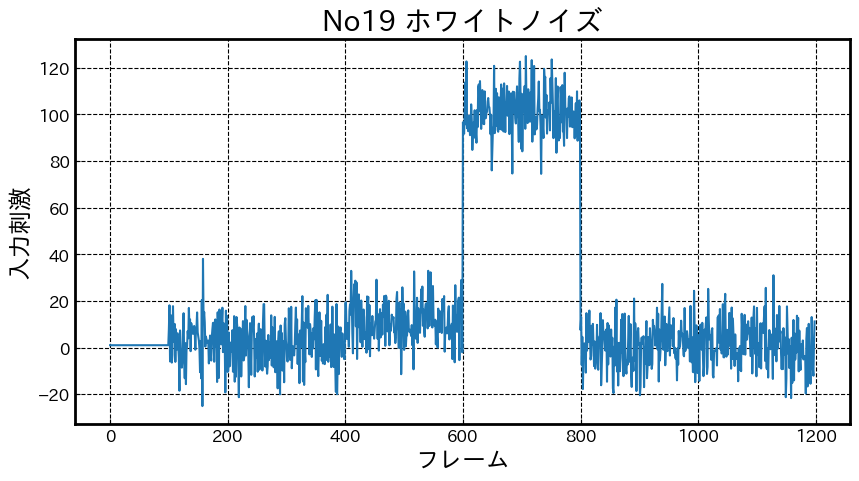

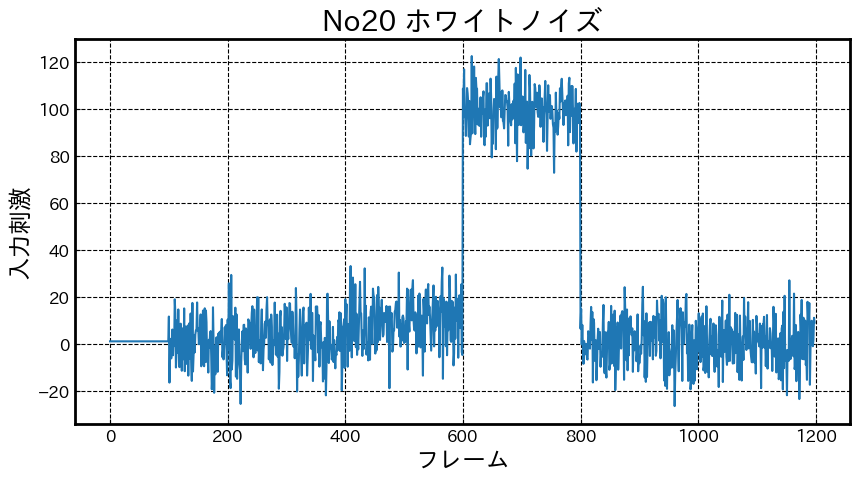

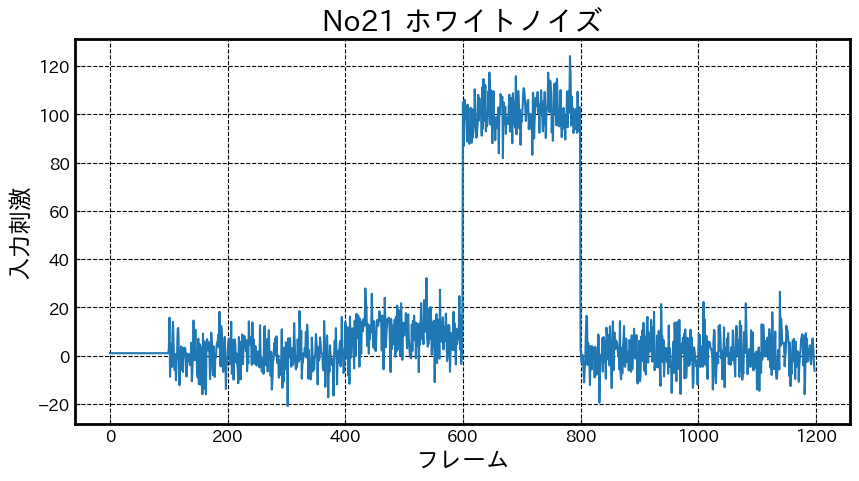

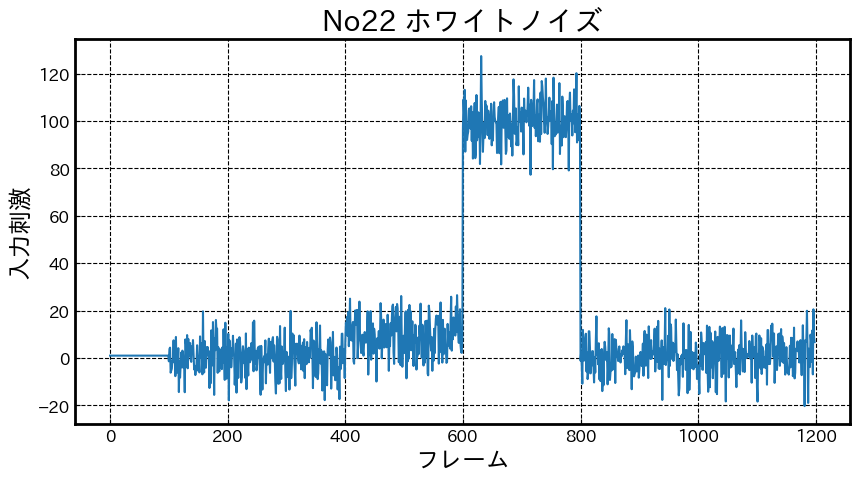

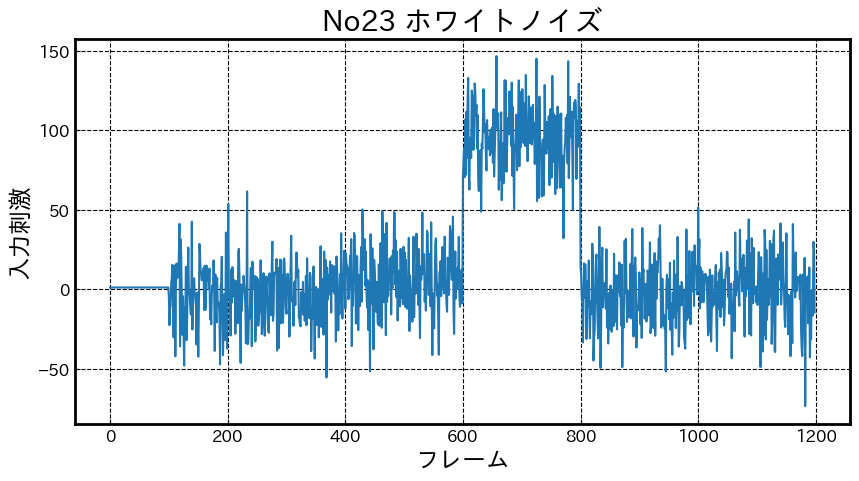

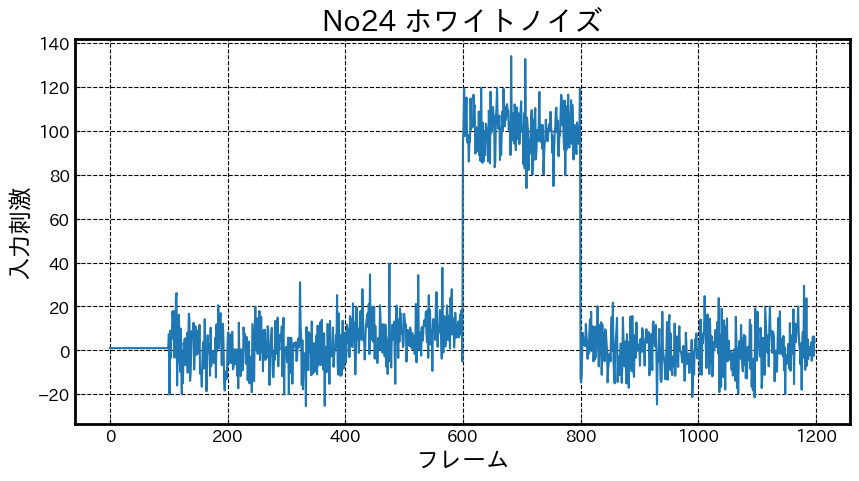

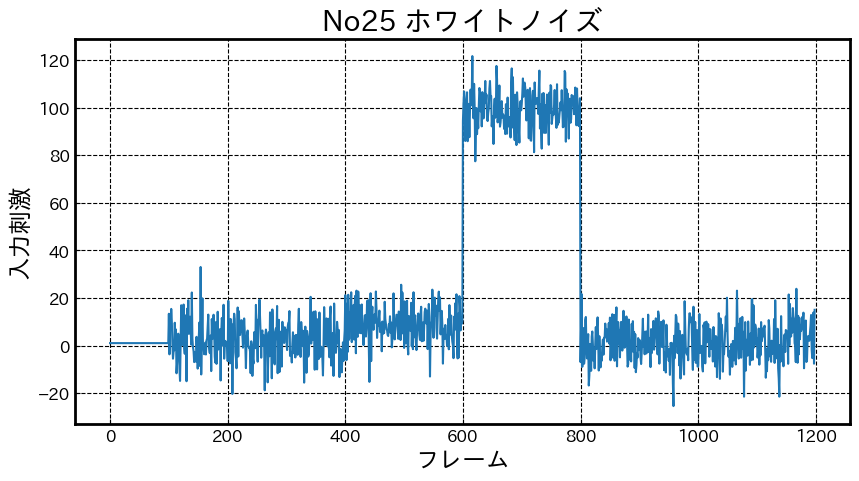

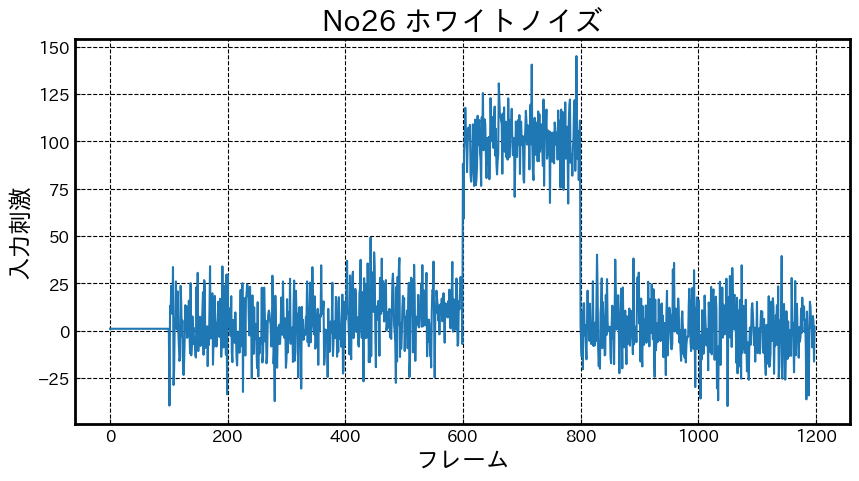

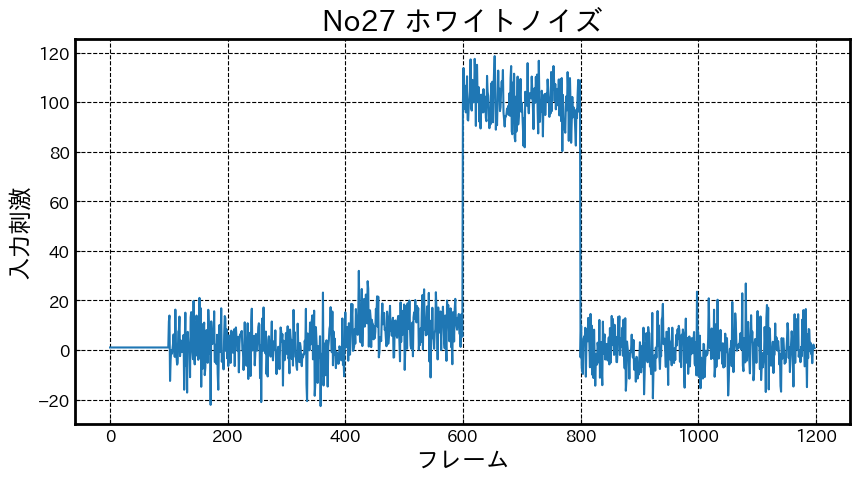

In [32]:
white_noise = x_si[:17, :]
for i in range(17):
    means = np.mean(proj_data[:, i*2+1])
    stds = np.std(proj_data[:, 2*i+1])
    noise = np.random.normal(means, stds, len(x_si[1, 100:]))
    white_noise[i, 100:] = noise + white_noise[i, 100:]
    
    plt.figure(figsize=(10, 5))
    plt.plot(white_noise[i, :])
    plt.xlabel("フレーム")
    plt.ylabel("入力刺激")
    plt.title("No{} ホワイトノイズ".format(i + 11))
    save_path = (f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/100/pre_value/No{i+11}_white_noise")
    
    
    #plt.savefig(save_path)
    plt.show()

# データ確認，設定

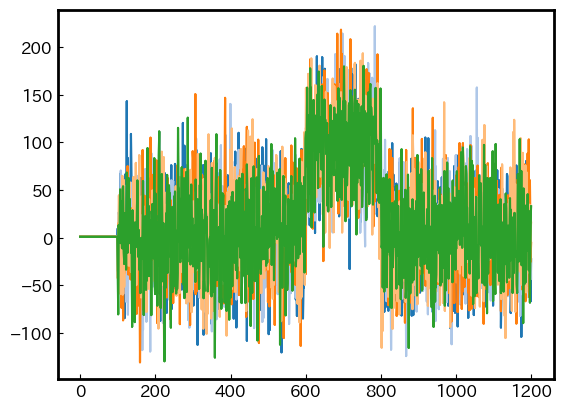

In [24]:
cmap = plt.get_cmap("tab20")

t = np.linspace(0, 1199, 1199)
# Check
plt.figure()
for i, x_ in enumerate(white_noise[12:]):
    plt.plot(t, x_, linestyle="-", color=cmap(i),label = "G")
    plt.plot(t, x_, linestyle="-", color=cmap(i),label = "G")
    
plt.grid()
plt.show()

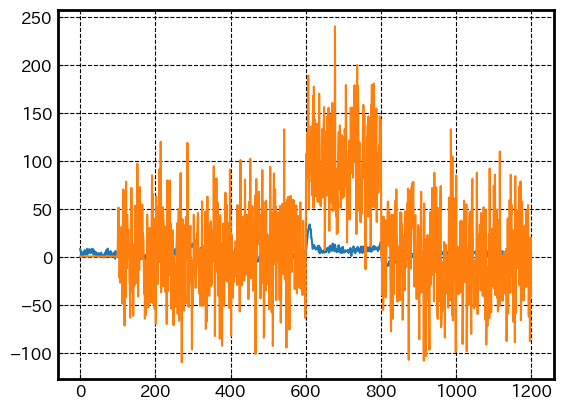

In [14]:
plt.plot(t, x_Q876x200[14, :])
plt.plot(t, x_si[4, :])

In [33]:
# train_Qx = x_Q876x200[10:, :]
# train_Qx[0, :] = x_Q876x200[0, :]
# train_Qx[1, :] = x_Q876x200[1, :]
# train_Qx[2:4, :] = x_Q876x200[10:12, :]
# train_Qx[4:, :] = x_Q876x200[13:26, :]
train_Qx = x_Q876x200[10:27, :]


In [34]:
train_Qx.shape

(17, 1199)

In [14]:
timesteps = 100

x_ = white_noise[:12, 100:]
y_ = train_Qx[:12, 100:]

train_x, train_y = make_dataset_for_stateful(x_, y_, timesteps)

In [15]:
x_.shape

(12, 1099)

# モデルの取得

In [63]:
#ハイパラ
x_dim = 1
h_dim = 64
z_dim = 8
learning_rate = 0.008
epochs = 60

model = VRNN(input_shape=(timesteps, x_dim), h_dim=h_dim, z_dim=z_dim)

# 学習


In [64]:
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss=loss)

#%load_ext tensorboard
# TensorBoardコールバックの作成
#tb_cb1 = tf.keras.callbacks.TensorBoard(
#histogram_freq=1,
#write_images=True
#)
#1, 5, 9, 11, 15, 16, 18, 20, 22, 25, 26


In [65]:
hist = model.fit(
    train_x, train_y,
    batch_size=12,
    epochs=epochs,
    #callbacks=[tb_cb1]
)

Epoch 1/60
999/999 [==============================] - 255s 246ms/step - total_cost: 47.8158 - loss: 45.9828 - kl_divergence: 1.8329
Epoch 2/60
999/999 [==============================] - 242s 242ms/step - total_cost: 35.9165 - loss: 35.8188 - kl_divergence: 0.0977
Epoch 3/60
999/999 [==============================] - 253s 253ms/step - total_cost: 26.4479 - loss: 26.4191 - kl_divergence: 0.0288
Epoch 4/60
999/999 [==============================] - 251s 251ms/step - total_cost: 22.1881 - loss: 22.1843 - kl_divergence: 0.0038
Epoch 5/60
999/999 [==============================] - 248s 248ms/step - total_cost: 20.7872 - loss: 20.7850 - kl_divergence: 0.0022
Epoch 6/60
999/999 [==============================] - 245s 245ms/step - total_cost: 16.9489 - loss: 16.9482 - kl_divergence: 6.9916e-04
Epoch 7/60
999/999 [==============================] - 251s 251ms/step - total_cost: 16.0220 - loss: 16.0205 - kl_divergence: 0.0015
Epoch 8/60
999/999 [==============================] - 243s 243ms/step - 

KeyboardInterrupt: 

# 推論

In [59]:
id = 27
pre_id = id - 1

# old
# x_2450_ = x_2450[pre_id].reshape(1, -1)

# test_x, _ = make_dataset_for_stateful(x_2450_, x_2450_, timesteps)

x_876_ = x_Q876x200[pre_id, 100:].reshape(1, -1)
inputs = white_noise[pre_id-10, 100:]
inputs_ = inputs.reshape(1, -1)


test_x, _ = make_dataset_for_stateful(inputs_, inputs_, timesteps)


outputs = model(test_x)

pred_y = outputs[0]






No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<function matplotlib.pyplot.show(close=None, block=None)>

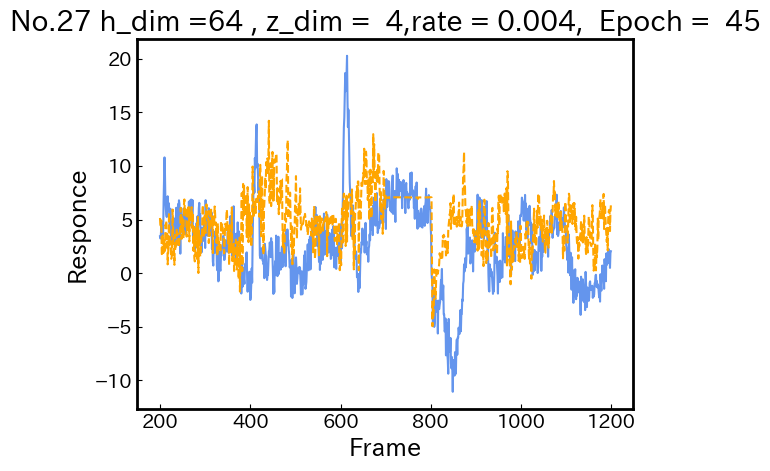

In [60]:
tt = np.linspace(200, 1199, 999)
plt.figure()
plt.title("No.{} h_dim ={:<3d}, z_dim = {:>2d},rate = {},  Epoch = {:>3d}".format(id, h_dim, z_dim,learning_rate, epochs))
plt.plot(tt, np.squeeze(x_Q876x200[pre_id, 200:]), linestyle="-", color="cornflowerblue")
#plt.plot(np.squeeze(inputs), linestyle="-", color="cornflowerblue")
plt.plot(tt, np.squeeze(pred_y), linestyle="--", color="orange")
#plt.plot(np.squeeze(inputs[0, 100:]))


plt.legend()
plt.grid()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('Frame', fontsize=18)
plt.ylabel('Responce', fontsize=18)

#plt.savefig(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/slice100/No_{id}_{z_dim}.png")
plt.show

In [29]:


for id in range(23, 28):
    pre_id = id - 1

    x_876_ = x_Q876x200[pre_id, 100:].reshape(1, -1)
    inputs = white_noise[pre_id-10, 100:]
    inputs_ = inputs.reshape(1, -1)


    test_x, _ = make_dataset_for_stateful(inputs_, x_876_, timesteps)


    outputs = model(test_x)

    pred_y = outputs[0]
    z = outputs[5]
    tt = np.linspace(200, 1199, 999)
    tt1 = np.linspace(100, 1199, 1099)
    # 予測結果プロット
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1]})
    ax1.plot(tt1, inputs)
    ax1.legend()
    ax1.set_xlabel("フレーム")
    ax1.set_ylabel("入力値")
    ax1.set_title(f"入力データ No.{id}")
    ax1.grid()
    # 右側の折れ線グラフ
    ax2.plot(tt, np.squeeze(pred_y), linestyle="--", color="orange", label ="予測値")
    ax2.plot(tt, np.squeeze(x_Q876x200[pre_id, 200:]), linestyle="-", color="cornflowerblue", label = "真の値")
    ax2.set_xlabel("フレーム")
    ax2.set_ylabel("応答値")
    ax2.set_title(f"出力データ　 No.{id}")
    ax2.legend()
    ax2.grid()
    plt.savefig(f"/data/Users/tsutsumi/VRNN/result/document/proj_1_new(h32, z8, rate0.005, 45)/predict_No{id}.png")

    # t-SNE プロット
    tsne = TSNE(n_components=2, perplexity=35, learning_rate=200, n_iter=1000)
    proj = tsne.fit_transform(z)
    tg = "z"

    plt.figure(figsize=(10, 5))
    plt.title(f"No.{id}")
    scatter = plt.scatter(proj[:, 0], proj[:, 1], c=pred_y, cmap="rainbow", alpha=0.9, vmin=min(pred_y), vmax=max(pred_y))
    plt.xlabel("潜在変数 1次元目")
    plt.ylabel("潜在変数 2次元目")
    plt.colorbar(scatter)
    plt.xlim(-70, 100)
    plt.ylim(-70, 70)
    plt.grid()
    plt.savefig(f"/data/Users/tsutsumi/VRNN/result/document/proj_1_new(h32, z8, rate0.005, 45)/t_SNE_No{id}.png")
    plt.close()

    # 時系列データプロット
    plt.figure(figsize=(10, 5))
    plt.title(f"No.{id}")
    plt.plot(proj[:, 0], label="Component 1", color="blue")
    plt.plot(proj[:, 1], label="Component 2", color="green")
    plt.plot(pred_y, label="Predicted", color="orange")
    plt.xlabel('Frame')
    plt.ylabel('Response')
    plt.grid()
    plt.legend()
    plt.savefig(f"/data/Users/tsutsumi/VRNN/result/document/proj_1_new(h32, z8, rate0.005, 45)/No{id}_tsne_{tg}12_.png")
    plt.close()

    np.save(f"/data/Users/tsutsumi/VRNN/result/document/proj_1_new(h32, z8, rate0.005, 45)/z_No{id}_h32z4rate0005.npy", z)
    np.save(f"/data/Users/tsutsumi/VRNN/result/document/proj_1_new(h32, z8, rate0.005, 45)/proj_No{id}_h32z4rate0005.npy", proj)
    np.save(f"/data/Users/tsutsumi/VRNN/result/document/proj_1_new(h32, z8, rate0.005, 45)/pred_No{id}_h32z4rate0005.npy", pred_y)
    

    # # アニメーション
    # num_frames = 1099
    # all_offsets = []
    # all_colors = []

    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    # scat = ax1.scatter(proj[:, 0], proj[:, 1], c=pred_y, cmap="rainbow", alpha=0.9)
    # ax1.set_title(f"No.{id}, t-SNE, z_dim = {z_dim:>2d}")
    # ax1.set_ylabel("潜在変数 1次元目")
    # ax1.set_xlabel("潜在変数 1次元目")
    # ax1.grid()
    # ax1.set_ylim(-80, 80)
    # ax1.set_xlim(-80, 80)
    # colorbar = plt.colorbar(scat, ax=ax1)

    # line, = ax2.plot([], [], linestyle="--", color="orange", label="Predicted")
    # ax2.set_title(f"No.{id}, Predicted Response")
    # ax2.set_ylabel("Response")
    # ax2.set_xlabel("Frame")
    # ax2.set_xlim(0, 1099)
    # ax2.grid()

    # def update(frame):
    #     all_offsets.append(proj[frame])
    #     all_colors.append(pred_y[frame])
    #     scat.set_offsets(all_offsets)
    #     scat.set_array(np.array(all_colors).flatten())
    #     line.set_data(range(frame + 1), np.squeeze(pred_y[:frame + 1]))
    #     return scat, line

    # ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=2, blit=True)
    # ani.save(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/100/No{id}_tsne_{tg}_pred.mp4", writer='ffmpeg')
    plt.close()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


## 記録

In [ ]:
id = 2
pre_id = id - 1

# old
# x_2450_ = x_2450[pre_id].reshape(1, -1)

# test_x, _ = make_dataset_for_stateful(x_2450_, x_2450_, timesteps)

x_876_ = x_G876x200[pre_id].reshape(1, -1)
inputs_ = white_noise[pre_id-20, :].reshape(1, -1)


test_x, _ = make_dataset_for_stateful(inputs_, x_876_, timesteps)


outputs = model(test_x)

pred_y = outputs[0]

plt.figure()
plt.title("No.{} h_dim ={:<3d}, z_dim = {:>2d},rate = {},  Epoch = {:>3d}".format(id, h_dim, z_dim,learning_rate, epochs))
plt.plot(np.squeeze(x_Q876x200[pre_id, 200:]), linestyle="-", color="cornflowerblue")
plt.plot(np.squeeze(pred_y), linestyle="--", color="orange")

plt.legend()
plt.grid()

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('Frame', fontsize=18)
plt.ylabel('Responce', fontsize=18)

plt.savefig(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/slice100/z4h32rate00001/No_{id}_{z_dim}.png")
plt.show

z = outputs[5]



prexity = 35
iter = 1000
learning = 200
pre = "35"
ite = "1000"
learn = "200"
tsne = TSNE(n_components=2, perplexity=prexity, learning_rate=learning, n_iter = iter)
#tsne = TSNE(n_components=2)
time = np.arange(0, 1189, 1)
time1 = np.arange(0, 2440, 1)
time2 = np.arange(0, 2440, 1)

proj = tsne.fit_transform(z)
tg = "z"

plt.figure(figsize=(10, 5))
plt.title("No.{:>2d}, tsne, h_dim ={:<3d}, z_dim = {:>2d},rate = {},  Epoch = {:>3d}".format(id, h_dim, z_dim,learning_rate, epochs))
scatter = plt.scatter(proj[:, 0], proj[:, 1], c=pred_y, cmap="rainbow", alpha=0.9, vmin=min(pred_y), vmax=max(pred_y))
#scatter = plt.scatter(z[:, 0], z[:, 1], c=pred_y, cmap="rainbow", alpha=0.9, vmin=min(pred_y), vmax=max(pred_y))
#scatter = plt.scatter(proj[:, 0], proj[:, 1], c=time, cmap="rainbow", alpha=0.9, vmin=min(time), vmax=max(time))


plt.xlabel("潜在変数　1次元目")
plt.ylabel("潜在変数　2次元目")
colorbar = plt.colorbar(scatter)

plt.xlim(-70,100)  # x軸の範囲設定
# plt.xticks(np.arange(-20, 20, 5))
# plt.yticks(np.arange(-20, 20, 5))
plt.ylim(-70,70)  # y軸の範囲設定

plt.grid()
plt.savefig(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/slice100/z4h32rate00001/t_SNE_No{id}_{tg}dim{z_dim}.png")


plt.figure(figsize=(10, 5))
plt.title("No.{:>2d}, tsne_{}, plot on time".format(id, tg, h_dim, z_dim, epochs))
plt.plot(proj[:, 0], label = "conpornent 1", color = "blue")
plt.plot(proj[:, 1], label = "conpornent 2", color = "green")
plt.plot(pred_y, label  = "pred", color = "orange")
plt.xlabel('Frame'.format(tg))
plt.ylabel('Response'.format(tg))

plt.grid()
plt.legend()
plt.savefig(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/slice100/z4h32rate00001/No{id}_tsne_{tg}12_.png")


np.save(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/slice100/z4h32rate00001/z_No{id}_h32z4rate001.npy", z)


# num_frames = 1099 # アニメーションのフレーム数
# prints_per_frame = 1099  # 各フレームのデータポイント数
# tg = "z"
# tt = np.linspace(0, 1, 1099)
# pred_y_= pred_y[100:]
# # プロットの設定
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
# scat = ax1.scatter(proj[:, 0], proj[:, 1], c=pred_y, cmap="rainbow", alpha=0.9)
# ax1.set_title("No.{:>2d}, tsne, z_dim = {:>2d}".format(id, z_dim))
# ax1.set_ylabel("潜在変数　1次元目")
# ax1.set_xlabel("潜在変数　1次元目")
# ax1.grid()
# ax1.set_ylim(-80, 80)  # y軸の範囲設定
# ax1.set_xlim(-80, 80)  # x軸の範囲設定
# colorbar = plt.colorbar(scat)
# time_text1 = ax1.text(0.5, 0.95, '', transform=ax1.transAxes, ha='center', fontsize=12)

# line, = ax2.plot(np.squeeze(pred_y_), linestyle="--", color="orange", label="pred")
# ax2.set_title("No.{:>2d}, pred_y".format(id))
# ax2.set_ylabel("フレーム")
# ax2.set_xlabel("応答反応")
# ax2.set_xlim(0, 1099)  # x軸の範囲設定
# ax2.grid()


# # plt.xticks(np.arange(-20, 20, 5))
# # plt.yticks(np.arange(-20, 20, 5))


# time_text2 = ax2.text(0.5, 0.95, '', transform=ax2.transAxes, ha='center', fontsize=12)
# all_offsets = []
# all_colors = []

# # アニメーションの更新関数
# def update(frame):
#     # scat.set_offsets(proj[frame])
#     # scat.set_array(pred_y[frame])
    
#     # # line.set_data(np.squeeze(pred_y[frame]))
#     line.set_data(range(frame + 1), np.squeeze(pred_y[:frame + 1]))
#     all_offsets.append(proj[frame])
#     all_colors.append(pred_y[frame])

#     # scatter plotのデータを更新
#     scat.set_offsets(all_offsets)
#     scat.set_array(np.array(all_colors).flatten())

#     time_text1.set_text(f'Time: {frame:.2f}')
#     time_text2.set_text(f'Time: {frame:.2f}')
    
#     return scat, line, time_text1, time_text2

# # アニメーションの作成
# ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=2, blit=True)

# アニメーションの保存（必要に応じて）
#ani.save(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/slice100/z4h32rate00001/No{id}_tsne_{tg}_pred.mp4", writer='ffmpeg')
plt.show()





KeyboardInterrupt: 

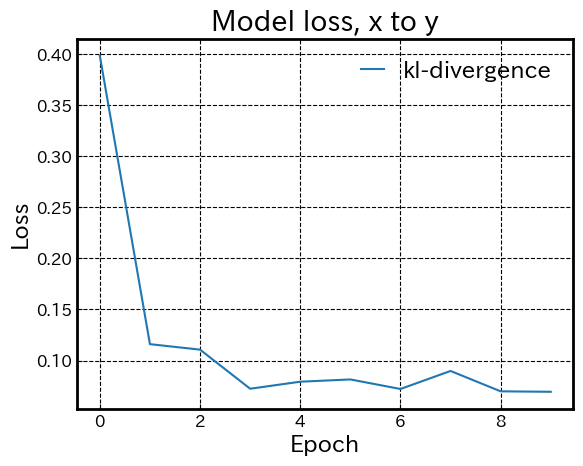

In [53]:
#学習曲線
#plt.plot(hist.history['loss'][:10], label = "loss")
plt.plot(hist.history['kl_divergence'][:10], label = "kl-divergence")
plt.title('Model loss, x to y')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
#plt.savefig(f"/data/Users/tsutsumi/VRNN/result/flame_1199/Reconstruct/slice100/Model_loss.png")
plt.show()


# 潜在変数と隠れ状態の可視化

In [54]:
z = outputs[5]
phi_z = outputs[6]
h = outputs[7]

# tsne

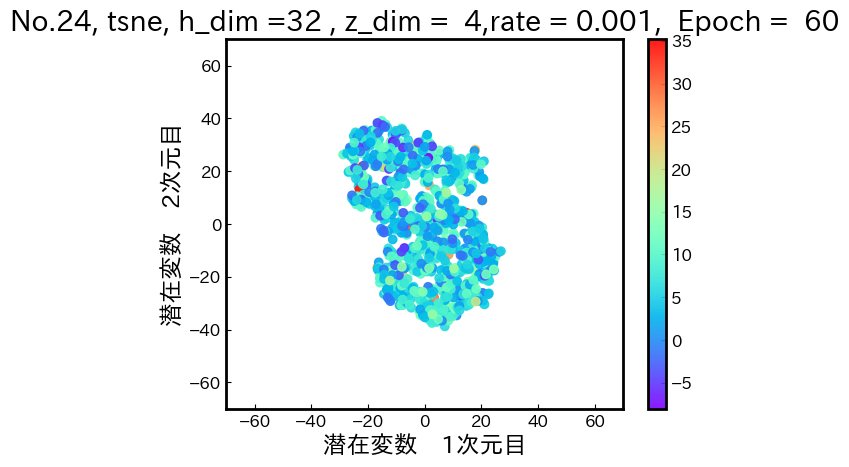

In [55]:
prexity = 35
iter = 1000
learning = 200
pre = "35"
ite = "1000"
learn = "200"
tsne = TSNE(n_components=2, perplexity=prexity, learning_rate=learning, n_iter = iter)
#tsne = TSNE(n_components=2)
time = np.arange(0, 1189, 1)
time1 = np.arange(0, 2440, 1)
time2 = np.arange(0, 2440, 1)

proj = tsne.fit_transform(z)
tg = "z"


plt.title("No.{:>2d}, tsne, h_dim ={:<3d}, z_dim = {:>2d},rate = {},  Epoch = {:>3d}".format(id, h_dim, z_dim,learning_rate, epochs))
scatter = plt.scatter(proj[:, 0], proj[:, 1], c=pred_y, cmap="rainbow", alpha=0.9, vmin=min(pred_y), vmax=max(pred_y))
#scatter = plt.scatter(z[:, 0], z[:, 1], c=pred_y, cmap="rainbow", alpha=0.9, vmin=min(pred_y), vmax=max(pred_y))
#scatter = plt.scatter(proj[:, 0], proj[:, 1], c=time, cmap="rainbow", alpha=0.9, vmin=min(time), vmax=max(time))


plt.xlabel("潜在変数　1次元目")
plt.ylabel("潜在変数　2次元目")
colorbar = plt.colorbar(scatter)

plt.xlim(-70,70)  # x軸の範囲設定
# plt.xticks(np.arange(-20, 20, 5))
# plt.yticks(np.arange(-20, 20, 5))
plt.ylim(-70,70)  # y軸の範囲設定

plt.grid()
#plt.savefig(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/slice100/t_SNE_No{id}_{tg}dim{z_dim}.png")

In [161]:
pred_y.shape

TensorShape([1099, 1])

In [151]:
z_ = z

In [160]:
np.save(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/slice100/z_No{id}_h32z4rate001.npy", z_)

In [4]:
proj = np.load("/data/Users/tsutsumi/VRNN/result/flame_1199/tsne/multi_tsne_proj.npy")

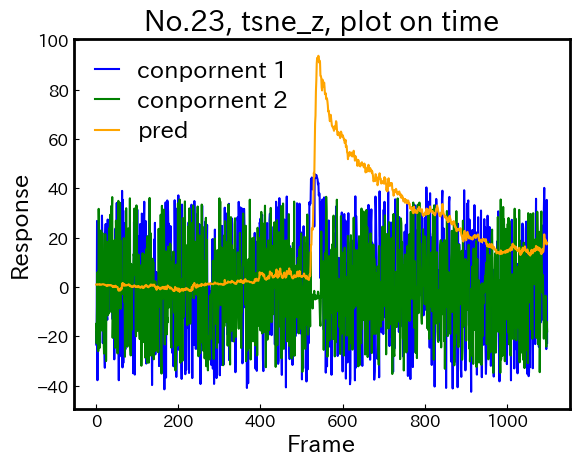

In [ ]:
plt.title("No.{:>2d}, tsne_{}, plot on time".format(id, tg, h_dim, z_dim, epochs))
plt.plot(proj[:, 0], label = "conpornent 1", color = "blue")
plt.plot(proj[:, 1], label = "conpornent 2", color = "green")
plt.plot(pred_y, label  = "pred", color = "orange")
plt.xlabel('Frame'.format(tg))
plt.ylabel('Response'.format(tg))

plt.grid()
plt.legend()
plt.savefig(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/slice100/No{id}_tsne_{tg}12_.png")


KeyboardInterrupt: 

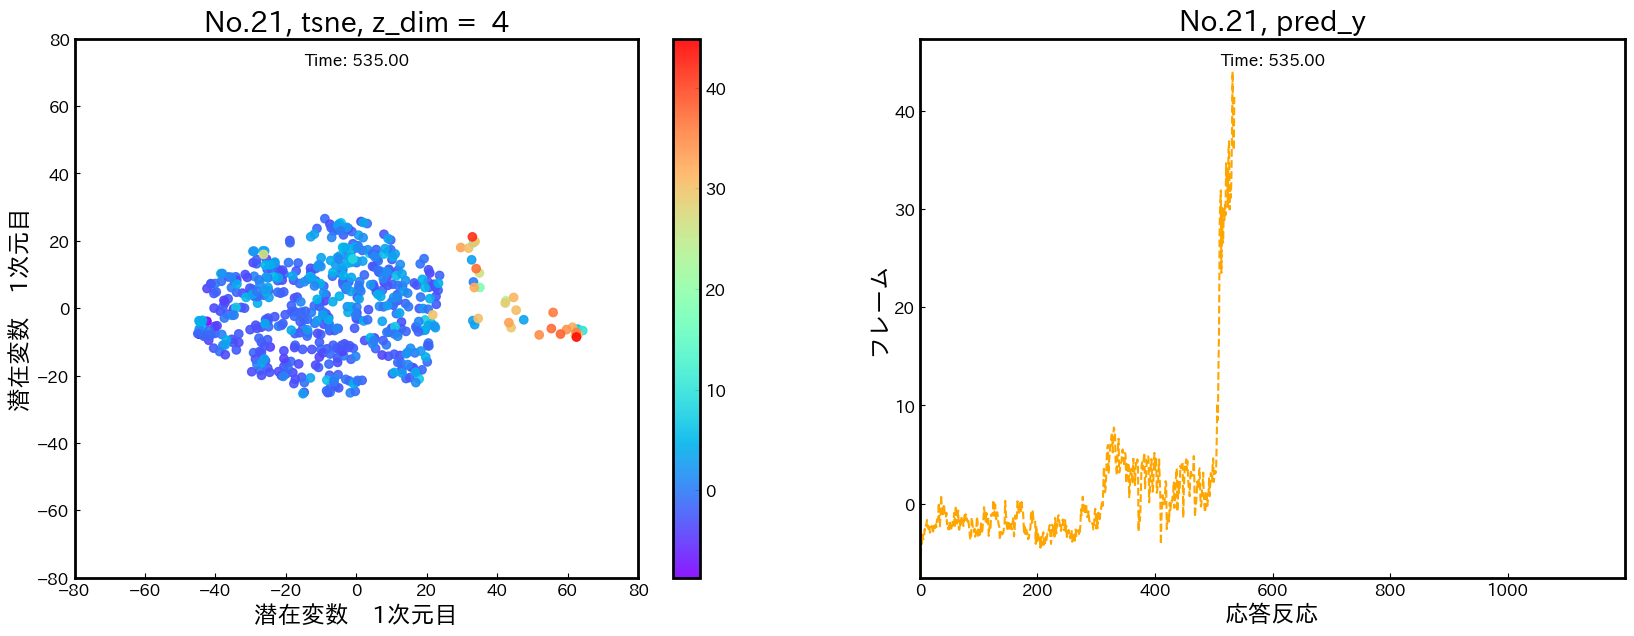

In [ ]:
num_frames = 1099 # アニメーションのフレーム数
prints_per_frame = 1099  # 各フレームのデータポイント数
tg = "z"
tt = np.linspace(0, 1, 1099)
pred_y_= pred_y[100:]
# プロットの設定
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
scat = ax1.scatter(proj[:, 0], proj[:, 1], c=pred_y, cmap="rainbow", alpha=0.9)
ax1.set_title("No.{:>2d}, tsne, z_dim = {:>2d}".format(id, z_dim))
ax1.set_ylabel("潜在変数　1次元目")
ax1.set_xlabel("潜在変数　1次元目")
ax1.grid()
ax1.set_ylim(-80, 80)  # y軸の範囲設定
ax1.set_xlim(-80, 80)  # x軸の範囲設定
colorbar = plt.colorbar(scat)
time_text1 = ax1.text(0.5, 0.95, '', transform=ax1.transAxes, ha='center', fontsize=12)

line, = ax2.plot(np.squeeze(pred_y_), linestyle="--", color="orange", label="pred")
ax2.set_title("No.{:>2d}, pred_y".format(id))
ax2.set_ylabel("フレーム")
ax2.set_xlabel("応答反応")
ax2.set_xlim(0, 1099)  # x軸の範囲設定
ax2.grid()


# plt.xticks(np.arange(-20, 20, 5))
# plt.yticks(np.arange(-20, 20, 5))


time_text2 = ax2.text(0.5, 0.95, '', transform=ax2.transAxes, ha='center', fontsize=12)
all_offsets = []
all_colors = []

# アニメーションの更新関数
def update(frame):
    # scat.set_offsets(proj[frame])
    # scat.set_array(pred_y[frame])
    
    # # line.set_data(np.squeeze(pred_y[frame]))
    line.set_data(range(frame + 1), np.squeeze(pred_y[:frame + 1]))
    all_offsets.append(proj[frame])
    all_colors.append(pred_y[frame])

    # scatter plotのデータを更新
    scat.set_offsets(all_offsets)
    scat.set_array(np.array(all_colors).flatten())

    time_text1.set_text(f'Time: {frame:.2f}')
    time_text2.set_text(f'Time: {frame:.2f}')
    
    return scat, line, time_text1, time_text2

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=2, blit=True)

# アニメーションの保存（必要に応じて）
ani.save(f"/data/Users/tsutsumi/VRNN/result/flame_1199/pred/slice100/No{id}_tsne_{tg}_pred.mp4", writer='ffmpeg')
plt.show()


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# 例: proj, pred_y, zなどの変数が定義されていると仮定
num_frames = 1189  # アニメーションのフレーム数
prints_per_frame = 1189  # 各フレームのデータポイント数
tg = "z"
tt = np.linspace(0, 1, 1189)

# プロットの設定
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

# ax1: 散布図の初期設定
scat = ax1.scatter(proj[:, 0], proj[:, 1], c=pred_y, cmap="rainbow", alpha=0.9)
ax1.set_title("No.{:>2d}, tsne_{}, , h_dim ={:<3d}, z_dim = {:>2d}, Epoch = {:>3d}".format(id, tg, h_dim, z_dim, epochs))
ax1.set_ylabel('{}[1]'.format(tg))
ax1.set_xlabel('{}[0]'.format(tg))

ax1.grid()
colorbar = plt.colorbar(scat)
time_text1 = ax1.text(0.5, 0.95, '', transform=ax1.transAxes, ha='center', fontsize=12)

# ax2: 予測値の変化を示すプロット
line, = ax2.plot(np.squeeze(pred_y), linestyle="--", color="orange", label="pred")
ax2.set_title("No.{:>2d}, pred_y".format(id))
ax2.set_ylabel('{}[1]'.format(tg))
ax2.set_xlabel('{}[0]'.format(tg))
ax2.grid()

time_text2 = ax2.text(0.5, 0.95, '', transform=ax2.transAxes, ha='center', fontsize=12)

# アニメーションの更新関数
def update(frame):
    # 点を繋ぐ線のデータを更新
    ax1.plot(proj[:frame+1, 0], proj[:frame+1, 1], c='black', alpha=0.7)  # `proj`は座標の配列
    
    # 散布図のデータを更新
    scat.set_offsets(proj[:frame+1])  # projの座標を更新
    scat.set_array(pred_y[:frame+1])  # pred_yを更新

    # 予測値のラインを更新
    line.set_data(range(frame + 1), np.squeeze(pred_y[:frame + 1])) 

    # 時間表示の更新
    time_text1.set_text(f'Time: {frame:.2f}')
    time_text2.set_text(f'Time: {frame:.2f}')
    
    return scat, line, time_text1, time_text2

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=8, blit=True)

# アニメーションの保存（必要に応じて）
ani.save(f"/data/Users/tsutsumi/VRNN/result/flame_1199/Val100＿line_No{id}_{tg}.mp4", writer='ffmpeg')
plt.show()


ValueError: Collections can only map rank 1 arrays

ValueError: Collections can only map rank 1 arrays

<Figure size 2000x700 with 3 Axes>

# PCA

In [ ]:
from sklearn.preprocessing import StandardScaler
# PCAライブラリをインポート
from sklearn.decomposition import PCA

In [ ]:
# 標準化
sc = StandardScaler()
z_std = sc.fit_transform(z)
phi_z_std = sc.fit_transform(phi_z)
h_std = sc.fit_transform(h)

pca_z = PCA(n_components=10, random_state=100)
pca_phi_z = PCA(n_components=2, random_state=100)
pca_h = PCA(n_components=2, random_state=100)

z_pca = pca_z.fit_transform(z_std)
phi_z_pca = pca_phi_z.fit_transform(phi_z_std)
h_pca = pca_h.fit_transform(h_std)



In [ ]:
eigenvalues_z = pca_z.explained_variance_
eigenvalues_phi_z = pca_phi_z.explained_variance_
eigenvalues_h = pca_h.explained_variance_

# 寄与率（explained variance ratio）
explained_variance_ratio_z = pca_z.explained_variance_ratio_
explained_variance_ratio_phi_z = pca_phi_z.explained_variance_ratio_
explained_variance_ratio_h = pca_h.explained_variance_ratio_

# 主成分負荷量（component loadings）
components_z = pca_z.components_
components_phi_z = pca_phi_z.components_
components_h = pca_h.components_

# 主成分得点（principal component scores）
scores_z = z_pca
scores_phi_z = phi_z_pca
scores_h = h_pca

print("Z data PCA results:")
print("固有値:", eigenvalues_z)
print("寄与率:", explained_variance_ratio_z)
print("主成分負荷量:", components_z)
print("主成分得点:", scores_z)

# print("\nPhi_Z data PCA results:")
# print("Eigenvalues:", eigenvalues_phi_z)
# print("Explained Variance Ratio:", explained_variance_ratio_phi_z)
# print("Components:", components_phi_z)
# print("Scores:", scores_phi_z)

# print("\nH data PCA results:")
# print("Eigenvalues:", eigenvalues_h)
# print("Explained Variance Ratio:", explained_variance_ratio_h)
# print("Components:", components_h)
# print("Scores:", scores_h)

In [ ]:
 plt.plot(tt, np.squeeze(pred_y), linestyle="--", color="orange", label="pred")

In [ ]:
plt.scatter(z_pca[:, 0], z_pca[:, 1], c=pred_y, cmap="rainbow", alpha=0.9)
tg1 = "z"
plt.colorbar()
plt.ylabel('{}[0]'.format(tg1))
plt.xlabel('{}[1]'.format(tg1))
plt.grid()
plt.title("No.{}, pca_{}, h_dim ={:<3d}, z_dim = {:>2d}, Epoch = {:>3d}".format(id, tg1, h_dim, z_dim, epochs))
plt.savefig(f"./result/flame_2450/No{id}_pca_{tg1}_pred.png")

In [ ]:
pred_y10 = []
z_pcax = []
z_pcay =[]
for i in range (244):
    pred_y10.append(pred_y[i*10])
    z_pcax.append(z_pca[i*10, 0])
    z_pcay.append(z_pca[i*10, 1])

plt.scatter(z_pcax, z_pcay,c = pred_y10,cmap="rainbow", alpha=0.9)

tg1 = "z"
plt.colorbar()
plt.ylabel('{}[0]'.format(tg1))
plt.xlabel('{}[1]'.format(tg1))
plt.grid()
plt.title("No.{}, pca_{}, h_dim ={:<3d}, z_dim = {:>2d}, Epoch = {:>3d}".format(id, tg1, h_dim, z_dim, epochs))
plt.savefig(f"./result/flame_2450/No{id}_pca_{tg1}_pred.png")

In [ ]:
num_frames = 10  # アニメーションのフレーム数
prints_per_frame = 10  # 各フレームのデータポイント数
tg = "z"
tt = np.linspace(0, 1, 2440)
# プロットの設定
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
#scat = ax1.scatter(z_pca[:, 0], z_pca[:, 1], c=pred_y, cmap="rainbow", alpha=0.9)
scat = ax1.scatter(z_pcax, z_pcay,c = pred_y10,cmap="rainbow", alpha=0.9)
ax1.set_title("No.{:>2d}, pca_{}, , h_dim ={:<3d}, z_dim = {:>2d}, Epoch = {:>3d}".format(id, tg, h_dim, z_dim, epochs))
ax1.set_ylabel('{}[1]'.format(tg))
ax1.set_xlabel('{}[0]'.format(tg))
ax1.grid()
colorbar = plt.colorbar(scat)
time_text1 = ax1.text(0.5, 0.95, '', transform=ax1.transAxes, ha='center', fontsize=12)

#line, = ax2.plot(np.squeeze(pred_y), linestyle="--", color="orange", label="pred")
line, = ax2.plot(np.squeeze(pred_y), linestyle="--", color="orange", label="pred")
ax2.set_title("No.{:>2d}, pred_y".format(id))
ax2.set_ylabel('{}[1]'.format(tg))
ax2.set_xlabel('{}[0]'.format(tg))
ax2.grid()

time_text2 = ax2.text(0.5, 0.95, '', transform=ax2.transAxes, ha='center', fontsize=12)
all_offsets = []
all_colors = []

# アニメーションの更新関数
def update(frame):
    # scat.set_offsets(proj[frame])
    # scat.set_array(pred_y[frame])
    
    # # line.set_data(np.squeeze(pred_y[frame]))
    line.set_data(range(frame*10 + 1), np.squeeze(pred_y[:frame*10 + 1]))
    all_offsets.append(z_pcax[frame])
    all_offsets.append(z_pcay[frame])
    
    all_colors.append(pred_y[frame*10])

    # scatter plotのデータを更新
    scat.set_offsets(all_offsets)
    scat.set_array(np.array(all_colors).flatten())

    time_text1.set_text(f'Time: {frame:.2f}')
    time_text2.set_text(f'Time: {frame:.2f}')
    
    return scat, line, time_text1, time_text2

# アニメーションの作成
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=100, blit=True)

# アニメーションの保存（必要に応じて）
ani.save(f"./result/flame_2450/Val100_No{id}_pca_{tg}_pred.mp4", writer='ffmpeg')
plt.show()

# decoder

In [47]:
# VRNNCellのインスタンスを取得
vrnn_cell_instance = model.layers[0]  

# VRNNCellのdecoderを取り出す
decoder_layer = vrnn_cell_instance.decoder

# decoderモデルを作成
decoder_model = keras.Sequential()
decoder_model.add(decoder_layer)

#decoder_layer.get_weights()

In [48]:
max_h = tf.reduce_max(h)
min_h = tf.reduce_min(h)

In [66]:
phi_z = outputs[6]
noise = tf.random.uniform(shape=[2440, 100], minval=min_h, maxval=max_h)
zero = tf.random.uniform(shape=[2440, 100], minval=0, maxval=0)

phi_z_zero = keras.layers.Concatenate(axis=(1))([h, zero])
phi_z_noise = keras.layers.Concatenate(axis=(1))([phi_z, noise])

phi_z_zero_decoded = decoder_model.predict(phi_z_zero)
phi_z_noise_decoded = decoder_model.predict(phi_z_noise)

77/77 [==============================] - 0s 1ms/step


In [53]:
phi_z.shape

TensorShape([2440, 100])

In [ ]:
phi_z_h.shape

In [ ]:
# z1 = np.linspace(-2, 2, 100)
# z2 = np.linspace(-1, 1, 100)
 
# num_of_rows = 10
# fig, ax = plt.subplots(nrows=num_of_rows, ncols=num_of_rows, figsize=(10, 10))
# for i, (z1_, z2_) in enumerate(zip(z1, z2)):
#     rand_z = np.array([z1_, z2_])
#     rand_z_h = keras.layers.Concatenate(axis=(1))([rand_z, h])  
#     sampled = decoder_model.predict(phi_z_h).reshape(1, 2)
#     ax[divmod(i, num_of_rows)].imshow(sampled.numpy().reshape(28, 28) * 255, cmap='Greys');
#     ax[divmod(i, num_of_rows)].set_axis_off()
# plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

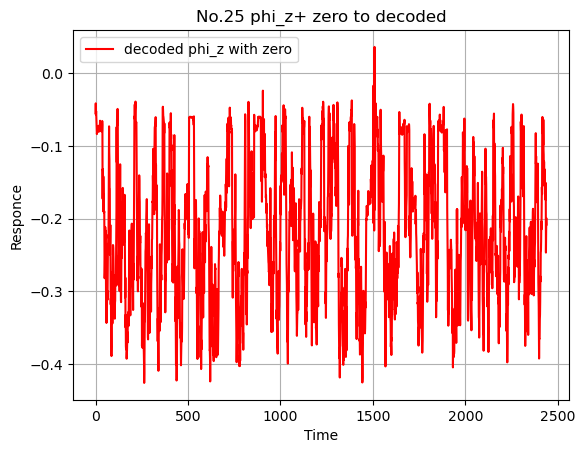

In [67]:
plt.figure()
plt.title("No.{} phi_z+ zero to decoded".format(id))
plt.plot(phi_z_zero_decoded, linestyle="-", color="red", label="decoded phi_z with zero")
#plt.plot(phi_z_noise_decoded, linestyle="-", color="blue", label="decoded phi_z with noise")
#plt.plot(np.squeeze(data_Qex[id, :]), linestyle="-", color="green",label = "x")
plt.legend()
plt.grid()
plt.ylabel('Responce')
plt.xlabel('Time')
plt.savefig(f"./result/flame_2450/decoded_No{id}_h_zero_pred24001.png")
plt.show

ValueError: x and y can be no greater than 2D, but have shapes (47800,) and (47800, 10, 1)

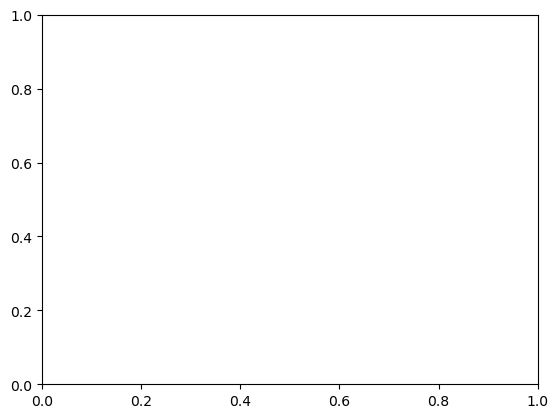

In [68]:
plt.plot(train_x)